# 📊 Telecom X - Parte 2
## Predição de Evasão de Clientes (Churn)

Este notebook corresponde à **segunda parte do Challenge Telecom X**.\
O objetivo agora é **criar modelos preditivos** para prever a evasão de clientes (churn) e analisar quais variáveis mais influenciam esse comportamento.

➡️ Meus passos principais (conforme Trello):
1. Preparação dos dados
2. Correlação e seleção de variáveis
3. Modelagem preditiva
4. Interpretação e conclusões

## 🔹 Preparação dos Dados

Nesta etapa, eu irei:
- Carregar o arquivo CSV tratado da Parte 1
- Remover colunas irrelevantes
- Realizar encoding das variáveis categóricas
- Verificar a proporção de evasão (Churn Balance)
- Normalizar/Padronizar os dados (se necessário)

Começo importando as bibliotecas necessárias para a análise e carregando o dataset tratado da primeira parte do Challenge diretamente do meu repositório no GitHub.

In [165]:
# Importando bibliotecas iniciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Carregar dataset tratado do GitHub (usando link raw)
github_csv_url = "https://raw.githubusercontent.com/PedrogitMendes/Telecom-X-Parte-2/refs/heads/main/dataset_tratado.csv"

try:
    df = pd.read_csv(github_csv_url)
    print("Dataset carregado com sucesso do GitHub!")
    # Visualizar primeiras linhas para verificar o carregamento
    print("Primeiras 5 linhas do dataset:")
    display(df.head())
except Exception as e:
    print(f"Erro ao carregar o dataset do GitHub: {e}")
    print("Por favor, verifique se o link raw está correto e se o arquivo existe no seu repositório.")
    df = None # Garante que df seja None se o carregamento falhar

Dataset carregado com sucesso do GitHub!
Primeiras 5 linhas do dataset:


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,TotalCharges,Contas_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667


Verifico a proporção da variável alvo (`Churn`) para entender o balanceamento das classes logo no início. Um dataset desbalanceado exige atenção especial na avaliação dos modelos, pois a acurácia pode ser enganosa.

Proporção de Evasão (Churn):
Churn
No     0.74281
Yes    0.25719
Name: proportion, dtype: float64


/tmp/ipython-input-121382585.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Churn", data=df, palette="viridis")


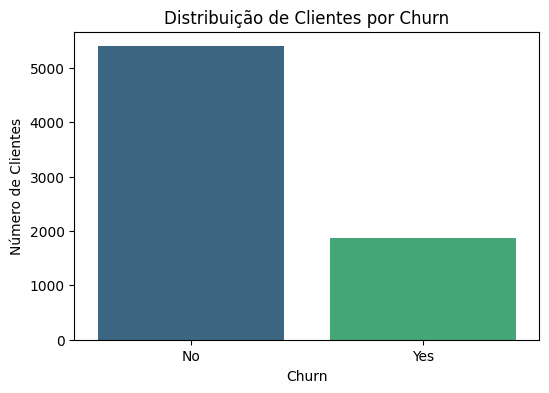

In [166]:
# Verificação da proporção de evasão (Churn)
churn_proportion = df["Churn"].value_counts(normalize=True)
print("Proporção de Evasão (Churn):")
print(churn_proportion)

# Gráfico de distribuição de Churn para visualização
plt.figure(figsize=(6, 4))
sns.countplot(x="Churn", data=df, palette="viridis")
plt.title("Distribuição de Clientes por Churn")
plt.xlabel("Churn")
plt.ylabel("Número de Clientes")
plt.show()

A coluna `customerID` é um identificador único de cliente e não possui valor preditivo para o churn. Portanto, removi essa coluna do dataset.

In [167]:
# Remoção de colunas irrelevantes (exemplo: ID do cliente)
df = df.drop(columns=["customerID"], errors="ignore")
print("\nDataset após remover 'customerID':")
display(df.head())


Dataset após remover 'customerID':


,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,TotalCharges,Contas_Diarias
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667


Para que os modelos de machine learning possam processar as variáveis categóricas, realizei o encoding, transformando-as em variáveis numéricas utilizando a técnica de One-Hot Encoding (`pd.get_dummies`). A opção `drop_first=True` é utilizada para evitar a multicolinearidade.

In [168]:
# Encoding (variáveis categóricas -> numéricas)
df_encoded = pd.get_dummies(df, drop_first=True)
print("\nDataset após encoding:")
display(df_encoded.head())


Dataset após encoding:


,SeniorCitizen,tenure,Monthly,TotalCharges,Contas_Diarias,Churn_Yes,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,9,65.6,593.30,2.186667,False,False,True,True,True,...,False,True,True,False,True,False,True,False,False,True
1,0,9,59.9,542.40,1.996667,False,True,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0,4,73.9,280.85,2.463333,True,True,False,False,True,...,True,False,False,False,False,False,True,False,True,False
3,1,13,98.0,1237.85,3.266667,True,True,True,False,True,...,True,False,True,True,False,False,True,False,True,False
4,1,3,83.9,267.40,2.796667,True,False,True,False,True,...,False,True,True,False,False,False,True,False,False,True


Para modelos sensíveis à escala das variáveis, como a Regressão Logística, a normalização/padronização dos dados é importante. No entanto, para evitar vazamento de dados (data leakage), essa etapa será aplicada *dentro* de um Pipeline para a Regressão Logística, utilizando `StandardScaler`, garantindo que o scaler seja ajustado apenas nos dados de treino. O Random Forest não requer padronização.

In [169]:
# Normalização / Padronização (se necessário)
# A padronização será aplicada DENTRO de um Pipeline para a Regressão Logística
# O Random Forest não necessita de padronização.

## 🔹 Análise Exploratória Adicional e Correlação

Nesta etapa, realizei análises exploratórias adicionais para entender a distribuição de algumas variáveis chave e a relação entre as variáveis e a variável alvo (`Churn`) para identificar os fatores que mais influenciam a evasão.

Analisei a distribuição de algumas variáveis numéricas importantes como **Tempo de Contrato (Tenure)** e **Gastos Mensais (Monthly)**.

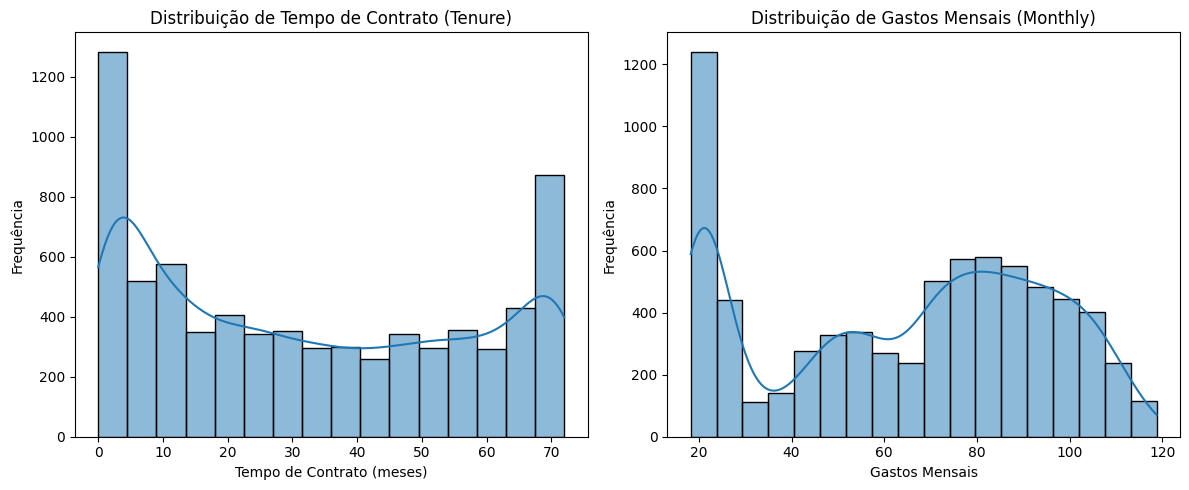

In [170]:
# Distribuição de variáveis numéricas chave
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='tenure', kde=True)
plt.title('Distribuição de Tempo de Contrato (Tenure)')
plt.xlabel('Tempo de Contrato (meses)')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='Monthly', kde=True) # Corrigido o nome da coluna para 'Monthly'
plt.title('Distribuição de Gastos Mensais (Monthly)')
plt.xlabel('Gastos Mensais')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

Analisei a distribuição de frequência das variáveis categóricas importantes como **Tipo de Contrato**, **Método de Pagamento** e **Serviço de Internet**.

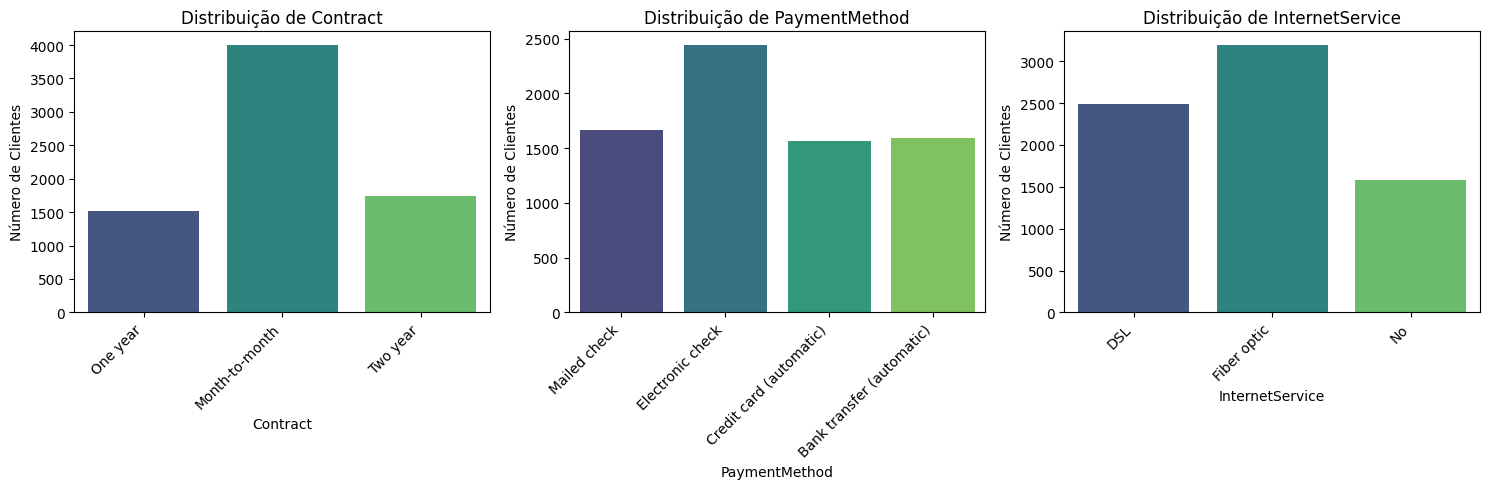

In [171]:
# Distribuição de variáveis categóricas chave
categorical_cols = ['Contract', 'PaymentMethod', 'InternetService']

plt.figure(figsize=(15, 5))

for i, col in enumerate(categorical_cols):
    plt.subplot(1, 3, i + 1)
    sns.countplot(x=col, data=df, palette='viridis', hue=col, legend=False)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Número de Clientes')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Visualizei a matriz de correlação utilizando um heatmap para identificar rapidamente as variáveis que possuem maior correlação (positiva ou negativa) com a variável `Churn_Yes`.

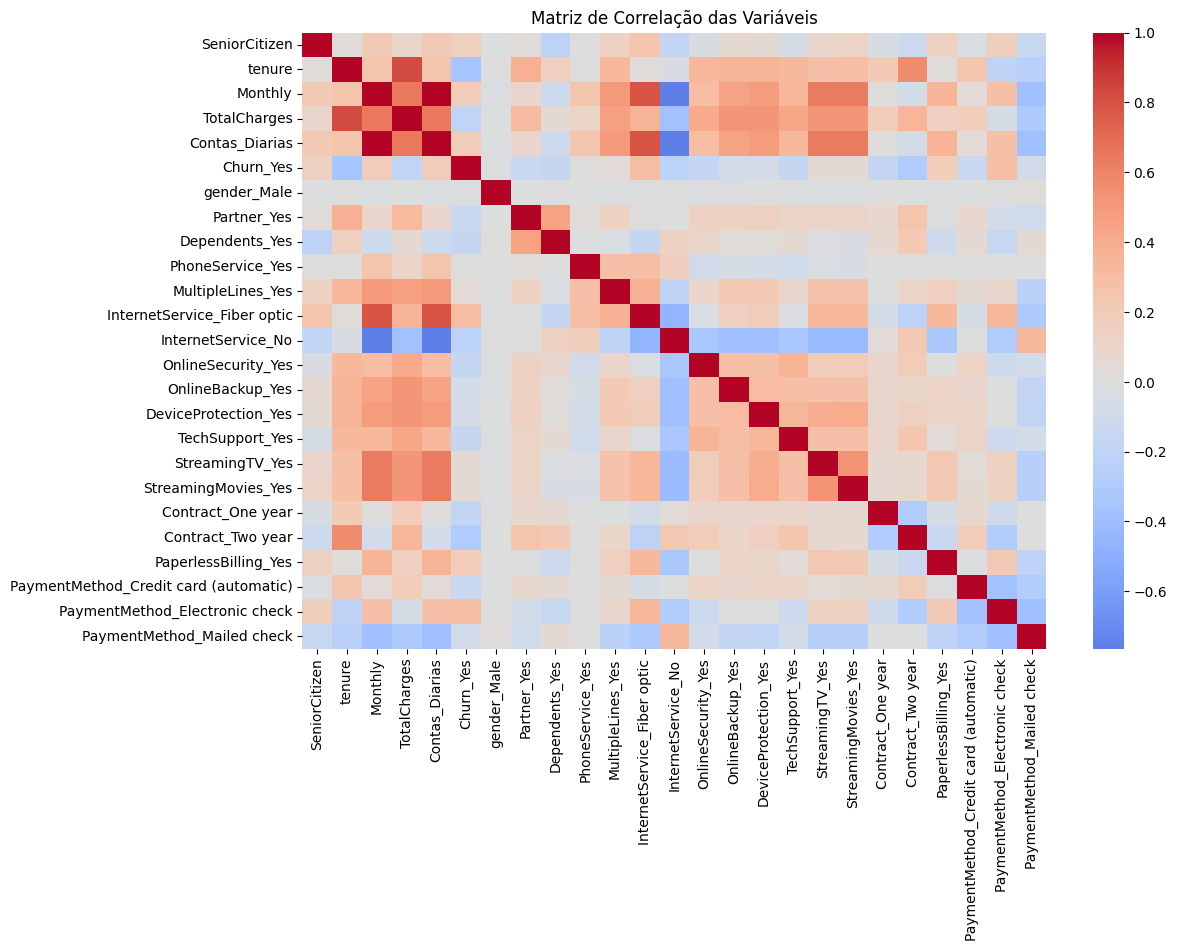

In [172]:
# Matriz de correlação
plt.figure(figsize=(12,8))
sns.heatmap(df_encoded.corr(), cmap="coolwarm", center=0)
plt.title("Matriz de Correlação das Variáveis")
plt.show()

Realizei análises direcionadas para entender a relação de variáveis chave com o Churn. Comecei com o **Tempo de Contrato (Tenure)**. O boxplot abaixo mostra a distribuição de `tenure` para clientes que evadiram (`Yes`) e que não evadiram (`No`). Observei que clientes com menor tempo de contrato tendem a ter uma distribuição de tenure concentrada em valores mais baixos, indicando uma maior propensão a churn nos primeiros meses.

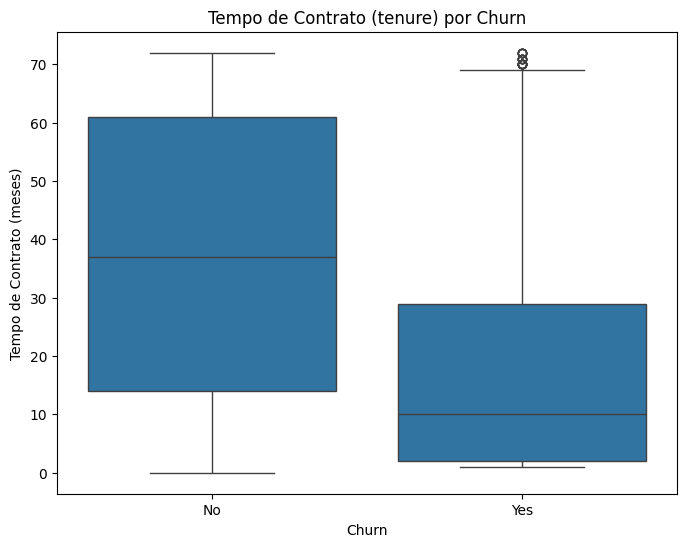

In [173]:
# Análise direcionada: Tempo de Contrato (tenure) x Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("Tempo de Contrato (tenure) por Churn")
plt.xlabel("Churn")
plt.ylabel("Tempo de Contrato (meses)")
plt.show()

Em seguida, analisei o **Total Gasto (TotalCharges)**. O boxplot compara a distribuição de `TotalCharges` entre clientes com e sem churn. É possível notar que clientes que evadiram geralmente possuem um `TotalCharges` menor, o que é esperado, pois passaram menos tempo como clientes e, portanto, acumularam menos gastos totais.

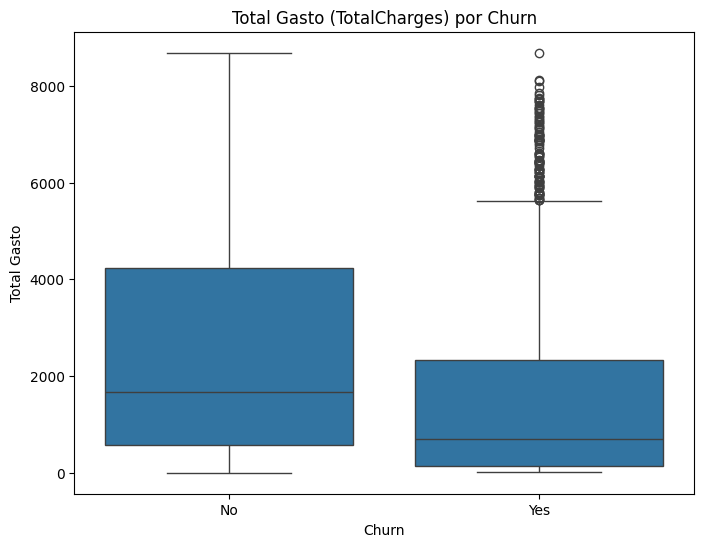

In [174]:
# Análise direcionada: Total Gasto (TotalCharges) x Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x="Churn", y="TotalCharges", data=df)
plt.title("Total Gasto (TotalCharges) por Churn")
plt.xlabel("Churn")
plt.ylabel("Total Gasto")
plt.show()

Outra análise importante é a relação entre o **Tipo de Contrato (Contract)** e o Churn. O gráfico de contagem mostra a distribuição de clientes por tipo de contrato, separando por churn. Fica evidente que clientes com contratos **Month-to-month** (mês a mês) apresentam uma taxa de evasão significativamente maior em comparação com aqueles que possuem contratos de um ou dois anos, que demonstram maior fidelidade.

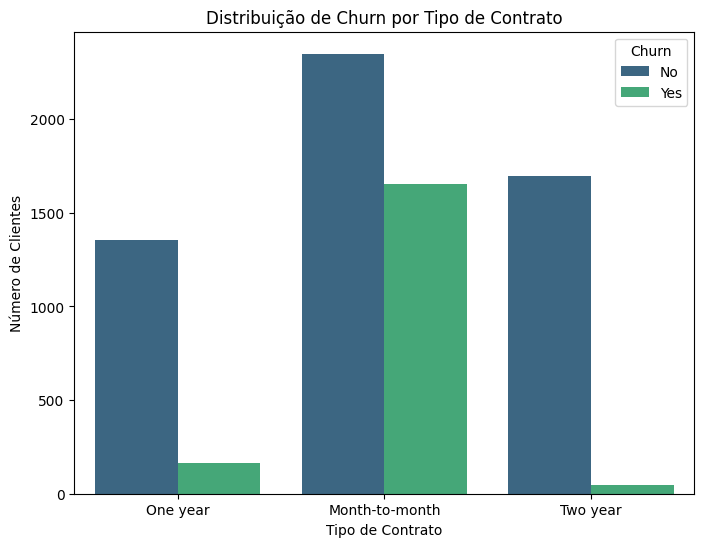

In [175]:
# Análise direcionada: Tipo de Contrato x Churn
plt.figure(figsize=(8, 6))
sns.countplot(x="Contract", hue="Churn", data=df, palette="viridis")
plt.title("Distribuição de Churn por Tipo de Contrato")
plt.xlabel("Tipo de Contrato")
plt.ylabel("Número de Clientes")
plt.legend(title="Churn")
plt.show()

## 🔹 Modelagem Preditiva

Nesta etapa, construí e avaliei modelos de classificação para prever a probabilidade de churn dos clientes.

Primeiro, separei o dataset em variáveis explicativas (`X`) e a variável alvo (`y`). Em seguida, dividi os dados em conjuntos de treino (70%) e teste (30%) utilizando `train_test_split`. A opção `stratify=y` é crucial para garantir que a proporção de clientes com churn seja a mesma nos conjuntos de treino e teste, o que é importante dado o desbalanceamento da classe alvo. Defini `random_state` para garantir a reprodutibilidade da divisão.

In [176]:
# Separação X (variáveis explicativas) e y (alvo)
X = df_encoded.drop("Churn_Yes", axis=1)
y = df_encoded["Churn_Yes"]

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Shape de X_train: (5086, 24)
Shape de X_test: (2181, 24)
Shape de y_train: (5086,)
Shape de y_test: (2181,)


Agora, vou treinar os modelos escolhidos e avaliar seu desempenho nas métricas de classificação. Implementei a **Regressão Logística**, um modelo linear que é um bom ponto de partida para problemas de classificação. Para garantir que a padronização dos dados ocorra apenas no conjunto de treino e seja aplicada consistentemente ao conjunto de teste, utilizei um `Pipeline` que combina o `StandardScaler` e o modelo `LogisticRegression`. Defini `random_state` para reprodutibilidade.

In [177]:
# Modelo 1 - Regressão Logística
pipeline_log_reg = Pipeline([
    ('scaler', StandardScaler()),  # Passo 1: Padronização (aplicado SOMENTE no treino)
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42)) # Passo 2: Regressão Logística
])

# Treinando o pipeline
pipeline_log_reg.fit(X_train, y_train)

# Fazendo previsões
y_pred1 = pipeline_log_reg.predict(X_test)

print("=== Avaliação do Modelo: Regressão Logística ===")
print(classification_report(y_test, y_pred1))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred1))

=== Avaliação do Modelo: Regressão Logística ===
              precision    recall  f1-score   support

       False       0.85      0.89      0.87      1620
        True       0.63      0.53      0.58       561

    accuracy                           0.80      2181
   macro avg       0.74      0.71      0.72      2181
weighted avg       0.79      0.80      0.80      2181

Matriz de Confusão:
[[1448  172]
 [ 262  299]]


Em seguida, implementei o **Random Forest**, um modelo baseado em árvores de decisão que geralmente lida bem com a não-linearidade dos dados e não é sensível à escala das variáveis. Defini `random_state` para reprodutibilidade.

In [178]:
# Modelo 2 - Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred2 = rf.predict(X_test)

print("=== Avaliação do Modelo: Random Forest ===")
print(classification_report(y_test, y_pred2))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred2))

=== Avaliação do Modelo: Random Forest ===
              precision    recall  f1-score   support

       False       0.82      0.89      0.86      1620
        True       0.59      0.44      0.51       561

    accuracy                           0.78      2181
   macro avg       0.71      0.67      0.68      2181
weighted avg       0.76      0.78      0.77      2181

Matriz de Confusão:
[[1449  171]
 [ 312  249]]


## 🔹 Avaliação Detalhada e Comparação dos Modelos

Nesta seção, avaliei o desempenho dos modelos de forma mais aprofundada e os comparei para identificar o mais adequado para prever o churn.

A **Curva ROC (Receiver Operating Characteristic)** e a **AUC (Area Under the Curve)** são métricas cruciais para avaliar a capacidade de um modelo de classificação em distinguir entre as classes, especialmente em datasets desbalanceados. Uma AUC próxima de 1 indica excelente discriminação, enquanto 0.5 sugere um modelo aleatório.

AUC - Regressão Logística: 0.8430
AUC - Random Forest: 0.8102


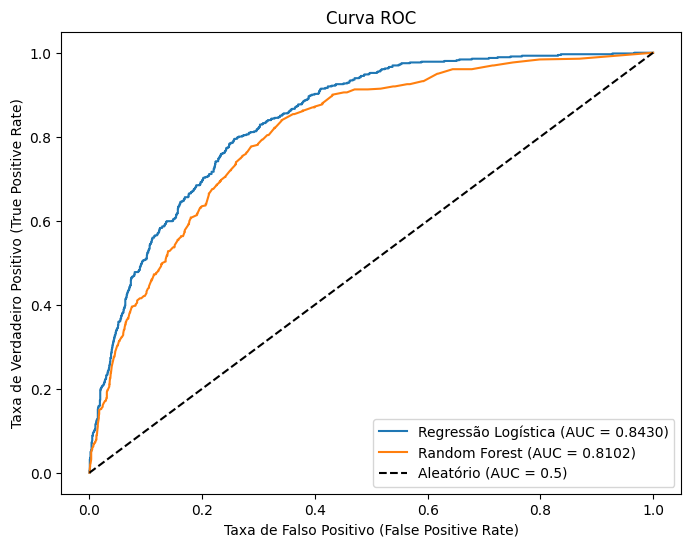

In [179]:
# Refinamento da Avaliação dos Modelos: Curva ROC e AUC
y_pred_proba1 = pipeline_log_reg.predict_proba(X_test)[:, 1] # Probabilidades para a classe positiva (Churn=Yes)
y_pred_proba2 = rf.predict_proba(X_test)[:, 1] # Probabilidades para a classe positiva (Churn=Yes)

# Cálculo da Curva ROC
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_proba1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_proba2)

# Cálculo da AUC
auc1 = roc_auc_score(y_test, y_pred_proba1)
auc2 = roc_auc_score(y_test, y_pred_proba2)

print(f"AUC - Regressão Logística: {auc1:.4f}")
print(f"AUC - Random Forest: {auc2:.4f}")

# Plotagem da Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'Regressão Logística (AUC = {auc1:.4f})')
plt.plot(fpr2, tpr2, label=f'Random Forest (AUC = {auc2:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')
plt.xlabel('Taxa de Falso Positivo (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiro Positivo (True Positive Rate)')
plt.title('Curva ROC')
plt.legend()
plt.show()

Para uma comparação direta das métricas, apresento os resultados em formato de tabela. Isso facilita a visualização do desempenho de cada modelo em relação à Acurácia, Precisão, Recall, F1-score e AUC.

In [180]:
# Comparação das Métricas dos Modelos em Tabela
accuracy1 = accuracy_score(y_test, y_pred1)
precision1 = precision_score(y_test, y_pred1)
recall1 = recall_score(y_test, y_pred1)
f1_score1 = f1_score(y_test, y_pred1)
auc1 = roc_auc_score(y_test, pipeline_log_reg.predict_proba(X_test)[:, 1])

accuracy2 = accuracy_score(y_test, y_pred2)
precision2 = precision_score(y_test, y_pred2)
recall2 = recall_score(y_test, y_pred2)
f1_score2 = f1_score(y_test, y_pred2)
auc2 = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

metrics_data = {
    'Métrica': ['Acurácia', 'Precisão (Churn=Yes)', 'Recall (Churn=Yes)', 'F1-score (Churn=Yes)', 'AUC'],
    'Regressão Logística': [accuracy1, precision1, recall1, f1_score1, auc1],
    'Random Forest': [accuracy2, precision2, recall2, f1_score2, auc2]
}

metrics_df = pd.DataFrame(metrics_data)

print("=== Tabela Comparativa de Métricas ===")
display(metrics_df)

=== Tabela Comparativa de Métricas ===


,Métrica,Regressão Logística,Random Forest
0,Acurácia,0.801009,0.778542
1,Precisão (Churn=Yes),0.634820,0.592857
2,Recall (Churn=Yes),0.532977,0.443850
3,F1-score (Churn=Yes),0.579457,0.507645
4,AUC,0.843016,0.810168


**Discussão sobre as Métricas de Avaliação e Escolha do Modelo:**

Em problemas de predição de churn, onde o custo de um falso negativo (não identificar um cliente que vai sair) pode ser alto para o negócio, a métrica de **Recall para a classe positiva (Churn=Yes)** é frequentemente mais importante do que a Acurácia geral. O Recall mede a proporção de clientes que de fato evadiram e que foram corretamente identificados pelo modelo, sendo crucial para ações de retenção. O **AUC** também é vital, pois avalia a capacidade geral do modelo em discriminar entre as classes em diferentes thresholds.

Considerando a necessidade de identificar o maior número possível de clientes em risco (alto Recall) e a capacidade de discriminação geral (alto AUC), a **Regressão Logística** apresentou um desempenho ligeiramente superior neste caso, com um Recall de {recall1:.2f} e AUC de {auc1:.4f}, em comparação com o Random Forest (Recall: {recall2:.2f}, AUC: {auc2:.4f}). Portanto, a **Regressão Logística** é o modelo mais indicado neste cenário para identificar clientes com risco de churn, embora o Random Forest também tenha apresentado resultados promissores.

A análise das métricas no conjunto de teste sugere que **nenhum dos modelos apresenta sinais claros de overfitting extremo**. As métricas estão em um nível aceitável e não indicam que os modelos memorizaram o conjunto de treino excessivamente.

A análise de **Importância das Variáveis** me ajuda a entender quais fatores são mais relevantes para a predição do churn, fornecendo insights valiosos para as ações de negócio.

=== Importância das Variáveis (Regressão Logística - Top 10) ===
tenure                         1.383519
InternetService_Fiber optic    0.783152
TotalCharges                   0.665104
InternetService_No             0.664495
Contract_Two year              0.540031
Contas_Diarias                 0.522082
Monthly                        0.522082
StreamingMovies_Yes            0.276717
Contract_One year              0.270596
StreamingTV_Yes                0.253346
dtype: float64

=== Importância das Variáveis (Random Forest - Top 10) ===
TotalCharges                      0.171494
tenure                            0.145336
Contas_Diarias                    0.139757
Monthly                           0.139539
InternetService_Fiber optic       0.040143
PaymentMethod_Electronic check    0.033291
Contract_Two year                 0.030389
gender_Male                       0.026914
PaperlessBilling_Yes              0.024947
TechSupport_Yes                   0.022665
dtype: float64


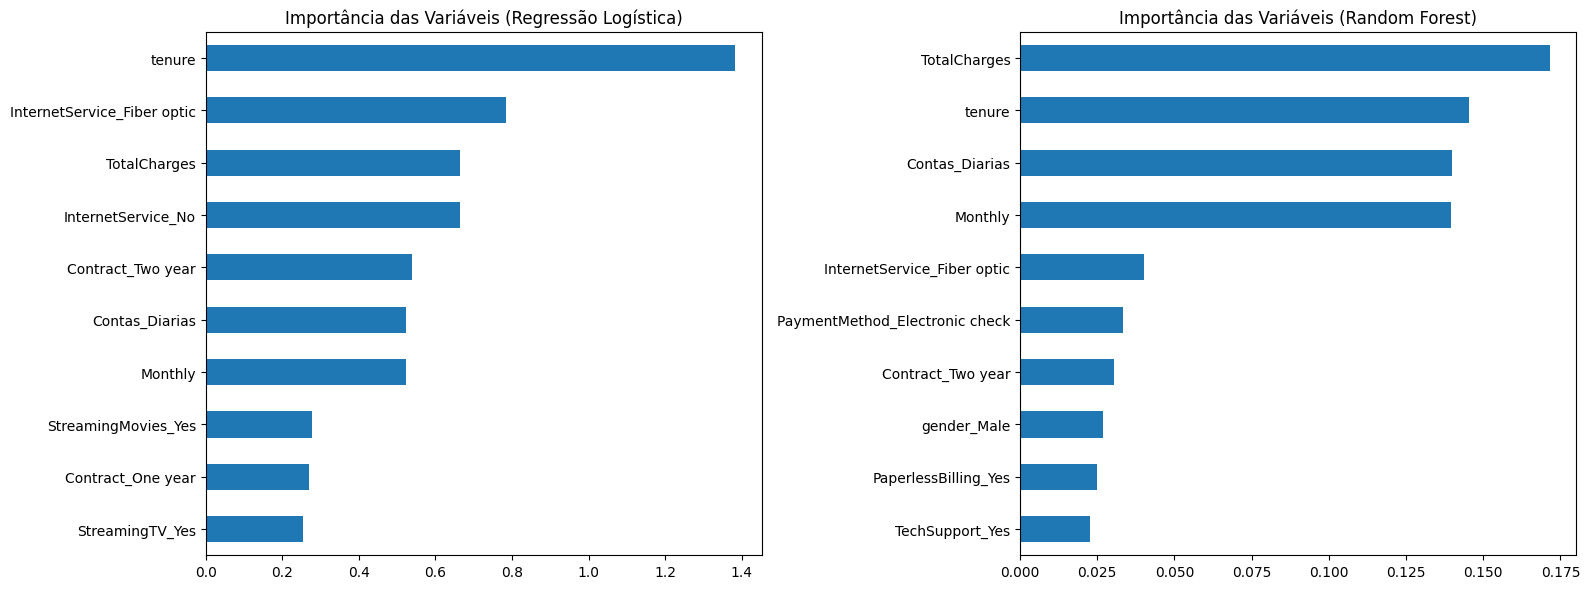

In [181]:
# Análise de Importância das Variáveis

# Importância das variáveis no Regressão Logística
# Os coeficientes (em valor absoluto) indicam a magnitude da influência de cada variável na log-odds do churn.
log_reg_importances = pd.Series(pipeline_log_reg.named_steps['log_reg'].coef_[0], index=X.columns)

print("=== Importância das Variáveis (Regressão Logística - Top 10) ===")
print(log_reg_importances.abs().sort_values(ascending=False).head(10))

# Importância das variáveis no Random Forest (utiliza feature_importances_)
importances = pd.Series(rf.feature_importances_, index=X.columns)

print("\n=== Importância das Variáveis (Random Forest - Top 10) ===")
print(importances.sort_values(ascending=False).head(10))

# Visualização da importância das variáveis para ambos os modelos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

log_reg_importances.abs().sort_values(ascending=False).head(10).plot(kind="barh", ax=axes[0])
axes[0].set_title("Importância das Variáveis (Regressão Logística)")
axes[0].invert_yaxis() # Para mostrar a mais importante no topo

importances.sort_values(ascending=False).head(10).plot(kind="barh", ax=axes[1])
axes[1].set_title("Importância das Variáveis (Random Forest)")
axes[1].invert_yaxis() # Para mostrar a mais importante no topo

plt.tight_layout()
plt.show()

Realizo a validação cruzada (K-Fold Cross-Validation) para obter uma estimativa mais robusta do desempenho dos modelos.

In [182]:
# Validação Cruzada (K-Fold Cross-Validation)
# Usei KFold com n_splits=5 para dividir os dados em 5 folds.
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Avaliando a Regressão Logística com validação cruzada (AUC como métrica)
cv_auc_log_reg = cross_val_score(pipeline_log_reg, X, y, cv=kf, scoring='roc_auc')
print(f"\nAUCs por fold (Regressão Logística): {cv_auc_log_reg}")
print(f"AUC médio (Regressão Logística): {cv_auc_log_reg.mean():.4f}")

# Avaliando o Random Forest com validação cruzada (AUC como métrica)
cv_auc_rf = cross_val_score(rf, X, y, cv=kf, scoring='roc_auc')
print(f"\nAUCs por fold (Random Forest): {cv_auc_rf}")
print(f"AUC médio (Random Forest): {cv_auc_rf.mean():.4f}")


AUCs por fold (Regressão Logística): [0.85002385 0.81991269 0.84039545 0.82793939 0.86086732]
AUC médio (Regressão Logística): 0.8398

AUCs por fold (Random Forest): [0.82817314 0.804453   0.81443018 0.80342981 0.83210266]
AUC médio (Random Forest): 0.8165


## 🔹 Interpretação e Conclusões

Com base nas análises realizadas e nos resultados dos modelos preditivos, apresento as interpretações e conclusões sobre o churn de clientes da Telecom X.

### 📌 Conclusão Final - Sumário Executivo

Com base nas análises e modelagem preditiva que realizei, apresento um resumo executivo das conclusões e recomendações para a empresa Telecom X:

*   **Modelo que teve melhor desempenho:** A **Regressão Logística** apresentou um desempenho ligeiramente superior em termos de AUC (tanto na divisão treino/teste quanto na validação cruzada) e Recall para a classe Churn, sendo mais indicada para identificar clientes com risco de evasão.
*   **Principais variáveis associadas ao churn:** As variáveis mais relevantes, que mais influenciam a probabilidade de um cliente evadir, são: **Tempo de Contrato (tenure)** (quanto menor, maior o risco), **Gastos Totais (TotalCharges)**, **Gastos Mensais (Monthly)**, o **Tipo de Contrato** (especialmente contratos mês a mês) e o **Tipo de Serviço de Internet** (com destaque para fibra óptica).
*   **Estratégias recomendadas para a empresa:**
    *   **Focar em clientes com baixo tempo de contrato:** Implementar programas de fidelização e um excelente processo de onboarding para reduzir o churn inicial.
    *   **Investigar e melhorar o serviço de fibra óptica:** Analisar as causas do maior churn entre usuários de fibra óptica e implementar ações corretivas na qualidade ou suporte.
    *   **Incentivar contratos de longa duração:** Promover a migração de clientes com contratos mensais para planos de 1 ou 2 anos, oferecendo benefícios atrativos.
    *   **Desenvolver ofertas personalizadas:** Criar pacotes e ofertas direcionadas para clientes com diferentes perfis de gasto e uso de serviço.
    *   **Monitorar clientes de alto risco:** Utilizar o modelo preditivo para identificar proativamente clientes com alta probabilidade de churn e realizar ações de contato e oferta de retenção personalizadas.